# Contenido

1. **Carga de librerías y datos**  
   - 1.a. Librerías  
   - 1.b. Carga de datos

2. **Optimización**  
   - 2.a. Filtrado
   - 2.b. Nearest Neighbour con probabilidades
   - 2.c. Visualización


# 1. Carga de librerías y datos

## 1.a. Librerías

In [1]:
import pandas as pd
import random 
import time
import os
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image
import plotly.io as pio

from Funciones_nearest_probabilidad import funcion_objetivo, cantidad_estaciones, encontrar_estaciones_cercanas, procesar_estaciones, localizacion_segun_ruta, graficar_rutas_camiones

## 1.b. Carga de datos

In [2]:
# Predicciones
predicciones = pd.read_csv('../../1-DATOS/3-DATOS DE RESULTADOS/PREDICCION/predicciones_test.csv', index_col = 0)
predicciones = predicciones[0:9].round()

# Capacidad de las estaciones 
capacidad = pd.read_parquet('../../1-DATOS/2-DATOS PROCESADOS/BICING/INFORMACION COMPLETA/CAPACIDAD.parquet')

# Tiempos de viaje entre estaciones
tiempos_viaje = pd.read_csv('../../1-DATOS/2-DATOS PROCESADOS/DISTANCIAS/Matriz de tiempos.csv', index_col = 0)

In [3]:
predicciones.head(5)

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,11.0,...,450.0,452.0,458.0,490.0,465.0,502.0,503.0,52.0,91.0,467.0
2023-10-01 00:00:00,9.0,15.0,2.0,8.0,4.0,8.0,12.0,18.0,16.0,16.0,...,5.0,27.0,9.0,2.0,9.0,6.0,6.0,15.0,27.0,9.0
2023-10-01 01:00:00,11.0,15.0,3.0,8.0,3.0,7.0,11.0,16.0,14.0,15.0,...,6.0,28.0,9.0,2.0,7.0,6.0,7.0,15.0,25.0,9.0
2023-10-01 02:00:00,13.0,15.0,3.0,8.0,3.0,7.0,10.0,14.0,12.0,16.0,...,6.0,29.0,9.0,2.0,7.0,7.0,9.0,14.0,24.0,9.0
2023-10-01 03:00:00,16.0,15.0,3.0,9.0,3.0,7.0,9.0,12.0,12.0,16.0,...,6.0,28.0,9.0,2.0,7.0,7.0,9.0,14.0,23.0,9.0
2023-10-01 04:00:00,15.0,15.0,3.0,9.0,3.0,7.0,8.0,11.0,11.0,16.0,...,5.0,27.0,9.0,1.0,7.0,6.0,10.0,13.0,24.0,9.0


In [4]:
# Selección de estaciones
estaciones = set(predicciones.columns)

# Filtrado y transformación de la matriz de tiempos
tiempos_viaje = (
    tiempos_viaje.loc[tiempos_viaje.index.astype(str).isin(estaciones), list(estaciones)]
    .div(60)
    .round()
)

# Filtrado del conjunto que contiene las capacidades y conversión a diccionario
capacidad.columns = ["Station", "Capacidad"]
capacidad['Station'] = capacidad['Station'].astype(float).astype(str)
capacidad = capacidad.loc[capacidad['Station'].isin(estaciones)]
capacidad_dict = capacidad.set_index('Station')['Capacidad'].to_dict()

# 2. Optimización

Se quiere minimizar la cantidad de horas que las estaciones del sistema se encuentran en riesgo de estar desabastecidas o saturadas.

In [5]:
valor = funcion_objetivo(predicciones[1:9], capacidad_dict, limite_inferior = 1, limite_superior = 3/4)

La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 420.


In [6]:
resumen = cantidad_estaciones(predicciones[1:9], capacidad_dict, limite_inferior = 1, limite_superior = 3/4)

La cantidad de estaciones en riesgo de estar desabastecidas en algún momento del período son: 97
La cantidad de estaciones en riesgo de estar saturadas en algún momento del período son: 49


In [7]:
resumen = cantidad_estaciones(predicciones[1:9], capacidad_dict, limite_inferior = 2, limite_superior = 2/3)

La cantidad de estaciones en riesgo de estar desabastecidas en algún momento del período son: 179
La cantidad de estaciones en riesgo de estar saturadas en algún momento del período son: 91


## 2.a. Filtrado


Se considera el segundo conjunto de datos (con más cantidad de estaciones), pero en el algoritmo tienen prioridad de visita las estaciones en riesgo con límite_inferior = 1 y límite_superior = 3/4 de la capacidad.

In [8]:
estacion_salida = pd.Series(['1.0'])
estaciones_intervenidas = resumen['Station']

if estacion_salida.iloc[0] in estaciones_intervenidas.values:
    estaciones_algoritmo = estaciones_intervenidas
else: 
    # Unión estación de salida con las que necesitan intervención
    estaciones_algoritmo = pd.concat([estacion_salida, estaciones_intervenidas], ignore_index=True)
    
# Filtrado en el conjunto de datos de las estaciones 
predicciones = predicciones[estaciones_algoritmo]
capacidad = capacidad[capacidad['Station'].isin(estaciones_algoritmo)]
capacidad_dict = capacidad.set_index('Station')['Capacidad'].to_dict()
tiempos_viaje.index = tiempos_viaje.index.astype(str)
tiempos_viaje = tiempos_viaje[estaciones_algoritmo]
tiempos_viaje = tiempos_viaje[tiempos_viaje.index.isin(estaciones_algoritmo)]

## 2.b. Nearest Neighbour con probabilidades

Función para ejecutar el algoritmo:

In [ ]:
random.seed(42)

num_minutes = predicciones.shape[0]*60

visitas_estaciones = []
tiempo_estaciones = []

def optimizacion_aleatoriedad(predicciones = predicciones, num_camiones = 2, capacidad_camion = 50, bicicletas_camion = 25, posicion_inicial = '1.0'):
    """
    Función para optimizar las rutas de los camiones, en función de la disponibilidad de bicicletas en las 
     estaciones de un sistema de bicicletas compartidas.

    Entradas:
    - predicciones: DataFrame que contiene datos predictivos sobre la cantidad de bicicletas en las estaciones.
    - num_camiones: Número de camiones disponibles para la operación (por defecto 2).
    - capacidad_camion: Capacidad máxima de bicicletas que puede llevar cada camión (por defecto 50).
    - bicicletas_camion: Número inicial de bicicletas disponibles en cada camión (por defecto 25).
    - posicion_inicial: Estación inicial donde comienzan los camiones (por defecto '1.0').

    Salidas:
    - resultados: DataFrame que muestra la ruta, momento de visita y bicicletas transportadas por cada camión 
      en cada iteración, correspondiente a la mejor solución encontrada según el criterio de la función objetivo.

    """
    valor_minimo = float('inf')
    iteraciones_bucle = 0
    tiempo_maximo = 600 # Este valor se puede modificar según las necesidades
    tiempo_inicio = time.time()

    # Ciclo principal controlado por el tiempo
    while time.time() - tiempo_inicio < tiempo_maximo:
        # Registro de visitas a estaciones
        visitas_estaciones = []
        tiempo_estaciones = []
        camiones = [
        {"id": i, "bicicletas_camion": bicicletas_camion, "posicion": posicion_inicial, "ruta": [posicion_inicial], "bicicletas_iteracion": [bicicletas_camion], "t": 0, "tiempo_vuelta": 0, "param" : False, "tiempo visita estaciones" : [0]}
        for i in range(num_camiones)
        ]

        iteraciones_bucle +=1
        print(time.time() - tiempo_inicio, iteraciones_bucle)

        data_inicial = predicciones.copy()

        while any(camion["t"] + camion["tiempo_vuelta"] < num_minutes - 60 for camion in camiones):
            for camion in camiones:
                restriccion = pd.DataFrame({'visita': visitas_estaciones, 'tiempo visita': tiempo_estaciones}) 
                if camion["t"] + camion["tiempo_vuelta"] >= num_minutes - 60:
                    continue
            
                lista_tiempos_vacía, lista_estaciones_vacía, lista_tiempos_llena, lista_estaciones_llena = encontrar_estaciones_cercanas(
                    camion["posicion"], camion["t"], estaciones_algoritmo, capacidad, tiempos_viaje, data_inicial, num_minutes, restriccion, posicion_inicial, limite_inferior=1, limite_superior=3/4
                )
                procesar_estaciones(camion, lista_tiempos_vacía, lista_estaciones_vacía, lista_tiempos_llena, lista_estaciones_llena, capacidad, data_inicial, tiempos_viaje, capacidad_camion, visitas_estaciones, tiempo_estaciones)

        # Retorno a la estación central
        for i, camion in enumerate(camiones):
            tiempo_vuelta = int(tiempos_viaje.loc[camion["posicion"], "1.0"])
            camion["t"] += tiempo_vuelta - 5 if camion["param"] else + tiempo_vuelta
            camion["posicion"] = "1.0"
            camion["ruta"].append("1.0")
            camion["tiempo visita estaciones"].append(camion["t"])
            camion["bicicletas_iteracion"].append(camion["bicicletas_camion"])


        # Calcular el valor de la función objetivo
        valor = funcion_objetivo(data_inicial[1:9], capacidad_dict, limite_inferior=1, limite_superior=3/4)
        if valor < valor_minimo:
            mejor_iteraciones = iteraciones_bucle
            mejores_camiones = camiones
            valor_minimo = valor

    dataframes = []
    for i, camion in enumerate(mejores_camiones):
        df = pd.DataFrame({
            "CAMIÓN": i + 1,
            "RUTA": camion["ruta"],
            "MOMENTO DE VISITA": camion["tiempo visita estaciones"],
            "BICICLETAS EN CAMIÓN": camion["bicicletas_iteracion"]
        })
        dataframes.append(df)
    resultados = pd.concat(dataframes, ignore_index=True)
    print(f'\nLa cantidad de minutos con estaciones en riesgo de estar desabastecidas o saturadas tras el reposicionamiento es: {valor_minimo}. Se ha obtenido este resultado en la iteracion {mejor_iteraciones}.')
    return resultados


In [10]:
resultados = optimizacion_aleatoriedad(predicciones = predicciones, num_camiones = 3, capacidad_camion = 50, bicicletas_camion = 25, posicion_inicial = '1.0')

0.0 1
La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 211.
58.22196984291077 2
La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 201.
109.56426668167114 3
La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 223.
156.48821210861206 4
La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 213.
205.92736792564392 5
La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 196.
256.3798098564148 6
La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 211.
304.66921377182007 7
La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 220.
353.8042733669281 8
La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 216.
446.4590301513672 9
La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 207.
564.2946062

In [11]:
resultados[resultados.CAMIÓN == 1] # Ejemplo

,CAMIÓN,RUTA,MOMENTO DE VISITA,BICICLETAS EN CAMIÓN
0,1,1.0,0,25
1,1,45.0,4,40
2,1,397.0,11,31
3,1,446.0,20,40
4,1,114.0,31,45
5,1,78.0,41,39
6,1,373.0,51,48
7,1,66.0,62,38
8,1,105.0,67,33
9,1,412.0,70,26


In [12]:
output_dir = '../../1-DATOS/3-DATOS DE RESULTADOS/OPTIMIZACION/'
camiones = resultados['CAMIÓN'].unique()

for camion in camiones:
    file_path = os.path.join(output_dir, f'camion_{camion}.csv')
    resultados[resultados['CAMIÓN'] == camion].to_csv(file_path, index=False)

## 2.c. Visualización (varios vehículos)


In [13]:
todas_localizaciones = pd.DataFrame()
for camion_id, grupo_camion in resultados.groupby("CAMIÓN"):
    ruta = grupo_camion["RUTA"].dropna().astype(str).tolist()

    localizacion = pd.read_parquet('../../1-DATOS/2-DATOS PROCESADOS/BICING/INFORMACION COMPLETA/GEOLOCALIZACION.parquet')
    localizacion = localizacion_segun_ruta(ruta, localizacion)
    localizacion["camion_id"] = f"Camión {camion_id}"

    todas_localizaciones = pd.concat([todas_localizaciones, localizacion], ignore_index=True)

print("Localizaciones de todas las rutas:")
print(todas_localizaciones)

Localizaciones de todas las rutas:
    station_id        lat       lon camion_id
0          1.0  41.397978  2.180107  Camión 1
1         45.0  41.391466  2.189371  Camión 1
2        397.0  41.388913  2.199311  Camión 1
3        446.0  41.377997  2.188423  Camión 1
4        114.0  41.376735  2.174008  Camión 1
..         ...        ...       ...       ...
115      270.0  41.448633  2.189837  Camión 3
116      460.0  41.451386  2.189472  Camión 3
117      451.0  41.414060  2.215049  Camión 3
118      423.0  41.420246  2.189485  Camión 3
119        1.0  41.397978  2.180107  Camión 3

[120 rows x 4 columns]


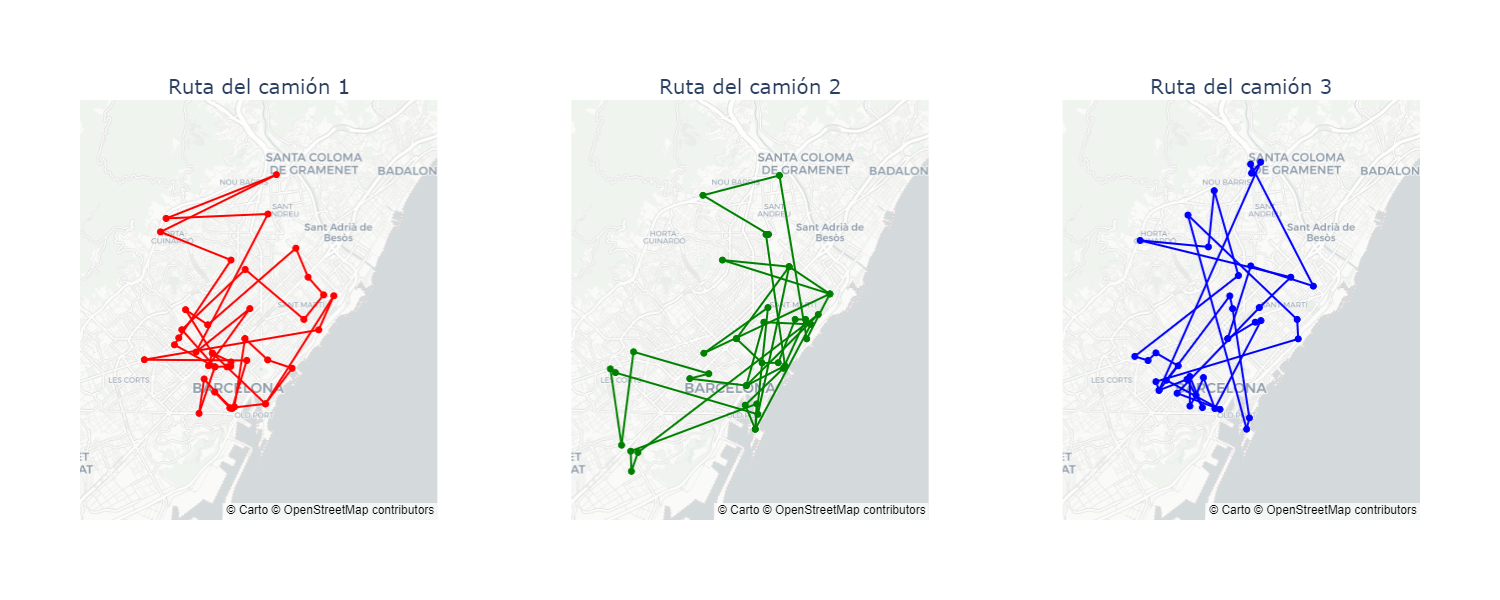

In [14]:
fig = graficar_rutas_camiones(todas_localizaciones)
# fig.write_image("rutas_camiones.png")
# fig.show()

static_image = pio.to_image(fig, format="png", engine="kaleido")
Image(static_image) # Muestra la imagen estática